In [1]:
from datetime import datetime

from gymnasium import register

from strategybuilder.backtesting.multi_day_backtesting import multi_day_backtesting
from strategybuilder.defaults.data.candle_data_indicators import generate_candle_data_pipeline, \
    CANDLE_DATA_OBSERVABLE_COLUMNS
from strategybuilder.rl.agent import create_taining_envs, train_agent
from strategybuilder.rl.env.long_only_env import LongOnlyStockTradingEnv

/Users/raulfarkas/projects/git/SampleTradingStrategies/venv/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [15]:
# Generate the pipeline to fetch and pre-process the data
default_data_pipeline = generate_candle_data_pipeline("MSFT", datetime(2016, 1, 1), datetime(2024, 12, 12))

# Run pipeline
data = default_data_pipeline.transform(None)

# Split data into training and testing
training_data = data.loc[datetime(2016, 1, 1):datetime(2023, 1, 15)]
testing_data = data.loc[datetime(2023, 1, 15):datetime(2024, 12, 30)]

register(
        id="LongOnlyStockTradingEnv-v0",
        entry_point=LongOnlyStockTradingEnv,
    )

/Users/raulfarkas/projects/git/SampleTradingStrategies/venv/lib/python3.11/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment LongOnlyStockTradingEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [16]:
# Create two environments, one for training and one for evaluation
train, evale = create_taining_envs(training_data, testing_data, "LongOnlyStockTradingEnv-v0", CANDLE_DATA_OBSERVABLE_COLUMNS, 25, 0, use_subproc=False, reset_at_random=True)

/Users/raulfarkas/projects/git/SampleTradingStrategies/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/raulfarkas/projects/git/StrategyBuilder/strategybuilder/rl/env/long_only_env.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data["period"] = self.data.index.to_period(trading_interval)


In [17]:
from strategybuilder.rl.agent import BEST_HYPERPARAMS
# Train the agent
agent = train_agent(train, evale, "./experiment/", eval_freq=4000, n_eval_episodes=50,
                            max_timesteps=len(training_data), checkpoint_save_freq=100_000 // 15, with_reporting=True,
                            **BEST_HYPERPARAMS)

Using cpu device
Training - End of period cash 102843.95500000007
Training - Day 2022-11-11
Training - End of period cash 100656.73999999987
Training - Day 2022-10-24
Training - End of period cash 100225.09999999992
Training - Day 2022-11-22
Training - End of period cash 100948.37000000004
Training - Day 2022-12-07
Training - Ep avg cash: 101168.54124999998
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 359      |
|    ep_rew_mean     | 0.255    |
| time/              |          |
|    fps             | 1559     |
|    iterations      | 1        |
|    time_elapsed    | 25       |
|    total_timesteps | 40000    |
---------------------------------
Training - End of period cash 100714.12000000005
Training - Day 2022-11-08
Training - End of period cash 99333.66999999987
Training - Day 2022-12-06
Training - End of period cash 99636.71000000002
Training - Day 2022-11-23
Training - End of period cash 100274.93999999993
Training - Day 2022-10-27
Tr

In [22]:
# Use the best version of the trained agent to backtest
all_stats, all_trades = multi_day_backtesting(testing_data, 100_000, CANDLE_DATA_OBSERVABLE_COLUMNS, "LongOnlyStockTradingEnv-v0", agent_path="./experiment/best_model.zip", commission=0)

/Users/raulfarkas/projects/git/SampleTradingStrategies/venv/lib/python3.11/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [23]:
all_stats.sort_index(inplace=True)

<Axes: xlabel='timestamp'>

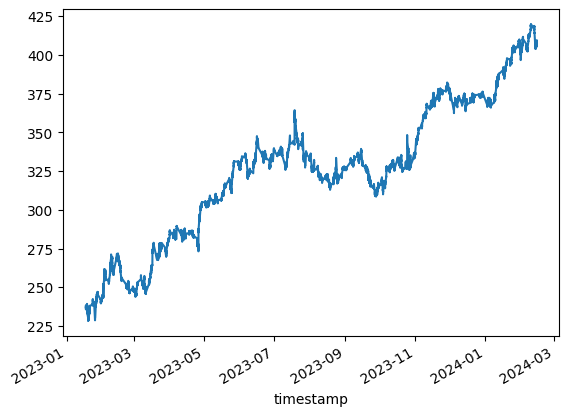

In [29]:
# Testing data closing price
testing_data["close"].plot()

<Axes: xlabel='End'>

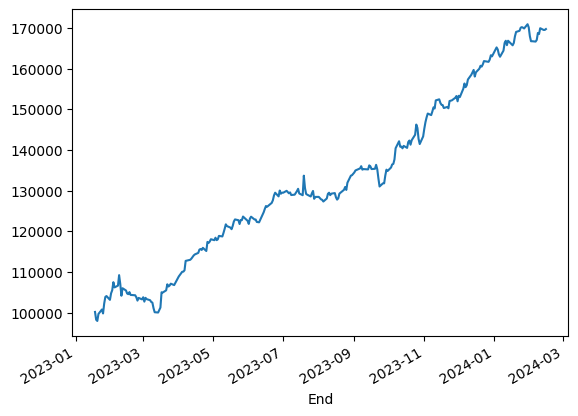

In [27]:
# Equity curve
all_stats["Equity Final [$]"].plot()

In [38]:
# Further metrics
print("Avg num daily trades", all_stats["# Trades"].mean())
print("Avg % daily return", all_stats["Return [%]"].mean())
print("Avg % daily winrate", all_stats["Win Rate [%]"].mean())

Avg num daily trades 51.4485294117647
Avg % daily return 0.1980705972142039
Avg % daily winrate 58.12724211162999
